# Fully-mixed poroelasticity: Splitting schemes

On the unit square domain $\Omega = (0,1) \times (0,1)$ we consider the boundary value problem (corresponding to one advance in time step of Biot's poroelasticity system). As analytical solution we take:
$$
    \begin{aligned}
      u_1 &= \sin(2\pi y) (\cos(2 \pi x) - 1) + \frac1{\mu +\lambda} \sin(\pi x) \sin(\pi y), \\
      u_2 &= \sin(2\pi x) (1 - \cos(2 \pi y)) + \frac1{\mu +\lambda} \sin(\pi x) \sin(\pi y), \\
      p &= \sin(\pi x) \sin(\pi y). 
    \end{aligned}
$$

Hence, we have $\boldsymbol{u}_{|\partial\Omega} = \boldsymbol{0}$, $p_{|\partial\Omega} = 0$. The right-hand side terms inferred from the exact solution are
$$
    \begin{aligned}
      f_1 &= \pi(\alpha\cos(\pi x)\sin(\pi y) - \pi(\cos(\pi x+\pi y)+4\mu\sin(2\pi y)(1-2\cos(2\pi x)) -\frac{2\mu}{\mu +\lambda}\sin(\pi x) \sin(\pi y)), \\
      f_2 &= \pi(\alpha\sin(\pi x)\cos(\pi y) - \pi(\cos(\pi x+\pi y)+4\mu\sin(2\pi x)(2\cos(2\pi y)-1) -\frac{2\mu}{\mu +\lambda}\sin(\pi x) \sin(\pi y)), \\
      g &= \left(2\kappa\pi^2 + \frac{c_0}{\tau}\right) \sin(\pi x) \sin(\pi y) + \frac{\alpha\pi}{(\lambda + \mu)\tau} \sin(\pi x + \pi y). 
    \end{aligned}
$$

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# problem data
dt = Constant(0.5)
lam = Constant(2.0)
c_0 = Constant(0.0002)
kappa = Constant(0.01)
alpha = Constant(0.1)  # declared as min(sqrt(kappa), 1)

# volumetric forcing term
f1 = Expression((
    'pi*(cos(pi*x[0])*sin(pi*x[1]) -pi*(cos(pi*x[0]+pi*x[1])+4*sin(2*pi*x[1])*(1-2*cos(2*pi*x[0]))))', 
    'pi*(sin(pi*x[0])*cos(pi*x[1]) -pi*(cos(pi*x[0]+pi*x[1])+4*sin(2*pi*x[0])*(2*cos(2*pi*x[1])-1)))'
              ), degree=3)
f2 = Expression((
    '(2*_mu/(_mu+_lam))*pi*pi*(sin(pi*x[0])*sin(pi*x[1]))', 
    '(2*_mu/(_mu+_lam))*pi*pi*(sin(pi*x[0])*sin(pi*x[1]))'
              ), degree=3, _mu=1.0, _lam=lam)

# fluid source term
g1 = Expression('(_kappa*2*pi*pi+2*_c_0)*sin(pi*x[0])*sin(pi*x[1])', degree=3, _kappa=kappa, _c_0=c_0) 
g2 = Expression('(2*pi/(_mu+_lam))*sin(pi*x[0]+pi*x[1])', degree=3, _mu=1.0, _lam=lam)

# analytical solutions (primary variables)
u_ex = Expression((
      '(sin(2*pi*x[1])*(cos(2*pi*x[0])-1) + (1.0/(_mu+_lam))*sin(pi*x[0])*sin(pi*x[1]))', 
      '(sin(2*pi*x[0])*(1-cos(2*pi*x[1])) + (1.0/(_mu+_lam))*sin(pi*x[0])*sin(pi*x[1]))'
              ), degree=4, _mu=1.0, _lam=lam)
p_ex = Expression('sin(pi*x[0])*sin(pi*x[1])', degree=4)

# analytical solutions (additional variables for hybrid-mixed formulation)
s1_ex = Expression((
      'pi*(-4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(1.0+_lam))*cos(pi*x[0])*sin(pi*x[1]) + (_lam/(1.0+_lam))*sin(pi*x[0]+pi*x[1]) - (1.0- _alpha)*sin(pi*x[0])*sin(pi*x[1])/pi)', 
      'pi*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(1.0+_lam))*sin(pi*x[0]+pi*x[1]))'
              ), degree=4, _lam=lam, _alpha=alpha)
s2_ex = Expression(( 
      'pi*(2*cos(2*pi*x[0])-2*cos(2*pi*x[1]) + (1.0/(1.0+_lam))*sin(pi*x[0]+pi*x[1]))',
      'pi*(4*sin(2*pi*x[0])*sin(2*pi*x[1]) + (2.0/(1.0+_lam))*sin(pi*x[0])*cos(pi*x[1]) + (_lam/(1.0+_lam))*sin(pi*x[0]+pi*x[1]) - (1.0- _alpha)*sin(pi*x[0])*sin(pi*x[1])/pi)',
              ), degree=4, _lam=lam, _alpha=alpha)
w_ex = Expression((
      '-_kappa*pi*(cos(pi*x[0])*sin(pi*x[1]))+2*_alpha*(sin(2*pi*x[1])*(cos(2*pi*x[0])-1) + (1.0/(1.0+_lam))*sin(pi*x[0])*sin(pi*x[1]))',
      '-_kappa*pi*(sin(pi*x[0])*cos(pi*x[1]))+2*_alpha*(sin(2*pi*x[0])*(1-cos(2*pi*x[1])) + (1.0/(1.0+_lam))*sin(pi*x[0])*sin(pi*x[1]))',
              ), degree=4, _kappa=kappa, _lam=lam, _alpha=alpha)

## Fixed-stress splitting

In [ ]:
def fs_mixedsplitted(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    reg_1 = 0
    reg_2 = 0
    #reg_1 = 8.0*beta**2/c_1
    #reg_2 = dt/sqrt(kappa)
    
    # 1. mesh generation
    mesh = UnitSquareMesh(n, n, 'crossed')
    #square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    #mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S1 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    S2 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    U = VectorElement('DG', mesh.ufl_cell(), 0)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    
    X1 = FunctionSpace(mesh, MixedElement([W, P]))
    X2 = FunctionSpace(mesh, MixedElement([S1, S2, U, Q]))

    # 3a. assembling flow problem   
    w, phi = TrialFunctions(X1)
    z, psi = TestFunctions(X1)
    
    af1 = (dt * psi * div(w) + dt * phi * div(z) + (c_1+reg_1) * phi * psi)  * dx 
    af2 = -(dt/kappa + reg_2) * dot(w, z) * dx
    af = af1 + af2

    Af = assemble(af)
    Afinv = LUSolver(Af)

    # 3b. assembling elasticity problem  
    s1, s2, u, q = TrialFunctions(X2)
    t1, t2, v, r = TestFunctions(X2)

    ae1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    ae2 = (u[0] * div(t1) + u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx
    ae3 = (r * (s1[1] - s2[0]) + q * (t1[1] - t2[0])) * dx 
    ae4 =  -(alpha**2/(dt*kappa)) * dot(u, v) * dx
    ae = ae1 + ae2 + ae3 + ae4

    Ae = assemble(ae)
    Aeinv = LUSolver(Ae)

    # 4. solve
    niter = 100
    tolerance = 1e-8

    # as initial guess we take the null solution (the one at previous time step)
    x1_old = Function(X1)
    x2_old = Function(X2)
    w_old, phi_old = x1_old.split()
    s1_old, s2_old, u_old, q_old = x2_old.split()
  
    for i in range(niter):
        x1 = Function(X1)
        Lf = (dt*(g1+g2)*psi-beta*(s1_old[0]+s2_old[1])*psi-(alpha/kappa)*dot(u_old,z)+reg_1*phi_old*psi-reg_2*dot(w_old,z))*dx
        bf = assemble(Lf)
        Afinv.solve(x1.vector(), bf)  
        w, phi = x1.split()
 
        x2 = Function(X2)
        Le = (-dot(f1+f2,v)-beta*(t1[0]+t2[1])*phi-(alpha/kappa)*dot(v,w))*dx
        be = assemble(Le)
        Aeinv.solve(x2.vector(), be)
        s1, s2, u, q = x2.split()
  
        error = (errornorm(w, w_old, 'Hdiv0') / norm(w, 'Hdiv0') +
                 errornorm(phi, phi_old, 'L2') / norm(phi, 'L2') +
                 errornorm(s1, s1_old, 'Hdiv') / norm(s1, 'Hdiv') +
                 errornorm(s2, s2_old, 'Hdiv') / norm(s2, 'Hdiv') +
                 errornorm(u, u_old, 'L2') / norm(u, 'L2') + 
                 errornorm(q, q_old, 'L2') / norm(q, 'L2'))
        print(' step={}: {:.3e}'.format(i, error))
        x1_old, x2_old = x1, x2
        w_old, phi_old = x1_old.split()
        s1_old, s2_old, u_old, q_old = x2_old.split()

        if error < tolerance:
            break
    
    # 5. error evaluation
    Y = FunctionSpace(mesh, 'DG', 1)
    qproj = project(s1_old[1] - s2_old[0], Y)
           
    l2err_u = errornorm(u_ex, u_old, 'L2')
    l2err_s = sqrt(errornorm(s1_ex, s1_old, 'L2')**2 + errornorm(s2_ex, s2_old, 'L2')**2)
    Hdiverr_s = sqrt(errornorm(s1_ex, s1_old, 'Hdiv0')**2 + errornorm(s2_ex, s2_old, 'Hdiv0')**2)
    l2err_p = errornorm(p_ex, phi_old, 'L2')
    l2err_w = errornorm(w_ex, w_old, 'L2')
    Hdiverr_w = errornorm(w_ex, w_old, 'Hdiv0')
    l2err_q = norm(qproj, 'L2')

    return l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
M_err=np.zeros((7,4))

for i in range(4):
    n = 8*(2**i)
    l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = fs_mixedsplitted(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = l2err_s
    M_err[2,i] = l2err_q 
    M_err[3,i] = Hdiverr_s
    M_err[4,i] = l2err_p 
    M_err[5,i] = l2err_w
    M_err[6,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_q={:.2e} Hdiverr_s={:.2e} '.format(n, l2err_u, l2err_s, l2err_q, Hdiverr_s))
    print('n={} l2err_p={:.2e} l2err_w={:.2e} Hdiverr_w={:.2e}'.format(n, l2err_p, l2err_w, Hdiverr_w))
    print()

 step=0: 6.000e+00
 step=1: 4.759e+00
 step=2: 1.368e+00
 step=3: 2.652e-01
 step=4: 1.190e-01
 step=5: 6.689e-02
 step=6: 3.804e-02
 step=7: 2.175e-02
 step=8: 1.247e-02
 step=9: 7.157e-03
 step=10: 4.113e-03
 step=11: 2.365e-03
 step=12: 1.360e-03
 step=13: 7.824e-04
 step=14: 4.501e-04
 step=15: 2.590e-04
 step=16: 1.490e-04
 step=17: 8.572e-05
 step=18: 4.932e-05
 step=19: 2.838e-05
 step=20: 1.633e-05
 step=21: 9.395e-06
 step=22: 5.406e-06
 step=23: 3.110e-06
 step=24: 1.790e-06
 step=25: 1.030e-06
 step=26: 5.925e-07
 step=27: 3.409e-07
 step=28: 1.961e-07
 step=29: 1.129e-07
 step=30: 6.493e-08
 step=31: 3.736e-08
 step=32: 2.150e-08
 step=33: 1.237e-08
 step=34: 7.117e-09
n=8 l2err_u=1.88e-01 l2err_s=4.27e-01 l2err_q=8.01e-02 Hdiverr_s=1.15e+01 
n=8 l2err_p=5.26e-02 l2err_w=4.77e-02 Hdiverr_w=2.74e-02

 step=0: 6.000e+00
 step=1: 4.914e+00
 step=2: 1.395e+00
 step=3: 2.672e-01
 step=4: 1.198e-01
 step=5: 6.668e-02
 step=6: 3.754e-02
 step=7: 2.124e-02
 step=8: 1.205e-02
 step=

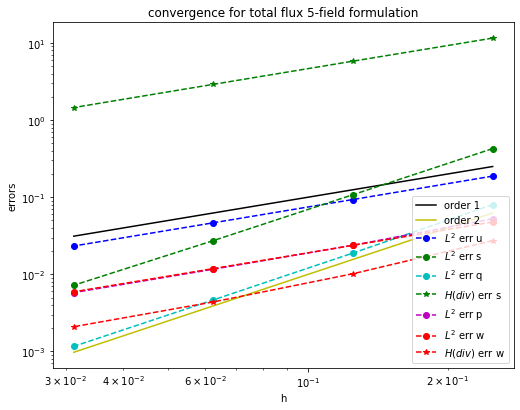

In [ ]:
# definition of the meshsize 
h = np.array([0.25/(2**i) for i in range(4)])

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.2, 0.2, 0.8, 0.8]) 

axes.loglog(h, h, 'k',label="order 1")
axes.loglog(h, h**2, 'y',label="order 2")
axes.loglog(h, M_err[0,:], 'b--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--o',label="$L^2$ err s")
axes.loglog(h, M_err[2,:], 'c--o',label="$L^2$ err q")
axes.loglog(h, M_err[3,:], 'g--*',label="$H(div)$ err s")
axes.loglog(h, M_err[4,:], 'm--o',label="$L^2$ err p")
axes.loglog(h, M_err[5,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M_err[6,:], 'r--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.savefig("conv_mixedbiot.png", dpi=200)
plt.show()

## Undrained splitting

In [ ]:
def ud_mixedsplitted(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    reg_1 = 0
    #reg_1 = beta**2/c_1
    reg_2 = 0
    #reg_2 = alpha**2/(4*dt*kappa)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S1 = FiniteElement('RT', mesh.ufl_cell(), 1)
    S2 = FiniteElement('RT', mesh.ufl_cell(), 1)
    U = VectorElement('DG', mesh.ufl_cell(), 0)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    
    X1 = FunctionSpace(mesh, MixedElement([S1, S2, U, Q]))
    X2 = FunctionSpace(mesh, MixedElement([W, P]))

    # 3b. assembling elasticity problem  
    s1, s2, u, q = TrialFunctions(X1)
    t1, t2, v, r = TestFunctions(X1)

    ae1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - (gamma+reg_1) * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    ae2 = (u[0] * div(t1) + u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx
    ae3 = (r * (s1[1] - s2[0]) + q * (t1[1] - t2[0])) * dx 
    ae4 =  -(alpha**2/(dt*kappa) + reg_2) * dot(u, v) * dx
    ae = ae1 + ae2 + ae3 + ae4

    Ae = assemble(ae)
    Aeinv = LUSolver(Ae)

    # 3a. assembling flow problem   
    w, phi = TrialFunctions(X2)
    z, psi = TestFunctions(X2)
    
    af1 = (dt * psi * div(w) + dt * phi * div(z) + c_1 * phi * psi) * dx 
    af2 = -(dt/kappa) * dot(w, z) * dx
    af = af1 + af2

    Af = assemble(af)
    Afinv = LUSolver(Af)

    # 4. solve
    niter = 100
    tolerance = 1e-8

    # as initial guess we take the null solution (the one at previous time step)
    x1_old = Function(X1)
    x2_old = Function(X2)
    s1_old, s2_old, u_old, q_old = x1_old.split()
    w_old, phi_old = x2_old.split()
  
    for i in range(niter):
        x1 = Function(X1)
        Le = (-dot(f1+f2,v)-beta*phi_old*(t1[0]+t2[1])-(alpha/kappa)*dot(w_old,v)
              -reg_1*(s1_old[0]+s2_old[1])*(t1[0]+t2[1])-reg_2*dot(u_old,v))*dx
        be = assemble(Le)
        Aeinv.solve(x1.vector(), be)
        s1, s2, u, q = x1.split()
 
        x2 = Function(X2)
        Lf = (dt*(g1+g2)*psi-beta*(s1[0]+s2[1])*psi-(alpha/kappa)*dot(u,z))*dx
        bf = assemble(Lf)
        Afinv.solve(x2.vector(), bf)  
        w, phi = x2.split()
  
        error = (errornorm(w, w_old, 'Hdiv') / norm(w, 'Hdiv') +
                 errornorm(phi, phi_old, 'L2') / norm(phi, 'L2') +
                 errornorm(s1, s1_old, 'Hdiv') / norm(s1, 'Hdiv') +
                 errornorm(s2, s2_old, 'Hdiv') / norm(s2, 'Hdiv') +
                 errornorm(u, u_old, 'L2') / norm(u, 'L2') + 
                 errornorm(q, q_old, 'L2') / norm(q, 'L2'))
        print(' step={}: {:.3e}'.format(i, error))
        x1_old, x2_old = x1, x2
        s1_old, s2_old, u_old, q_old = x1_old.split()
        w_old, phi_old = x2_old.split()

        if error < tolerance:
            break
    
    # 5. error evaluation
    Y = FunctionSpace(mesh, 'DG', 1)
    qproj = project(s1_old[1] - s2_old[0], Y)
           
    l2err_u = errornorm(u_ex, u_old, 'L2')
    l2err_s = sqrt(errornorm(s1_ex, s1_old, 'L2')**2 + errornorm(s2_ex, s2_old, 'L2')**2)
    Hdiverr_s = sqrt(errornorm(s1_ex, s1_old, 'Hdiv0')**2 + errornorm(s2_ex, s2_old, 'Hdiv0')**2)
    l2err_p = errornorm(p_ex, phi_old, 'L2')
    l2err_w = errornorm(w_ex, w_old, 'L2')
    Hdiverr_w = errornorm(w_ex, w_old, 'Hdiv0')
    l2err_q = norm(qproj, 'L2')

    return l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
M_err=np.zeros((7,4))

for i in range(4):
    n = 8*(2**i)
    l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = ud_mixedsplitted(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = l2err_s
    M_err[2,i] = l2err_q 
    M_err[3,i] = Hdiverr_s
    M_err[4,i] = l2err_p 
    M_err[5,i] = l2err_w
    M_err[6,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_q={:.2e} Hdiverr_s={:.2e} '.format(n, l2err_u, l2err_s, l2err_q, Hdiverr_s))
    print('n={} l2err_p={:.2e} l2err_w={:.2e} Hdiverr_w={:.2e}'.format(n, l2err_p, l2err_w, Hdiverr_w))
    print()

 step=0: 6.000e+00
 step=1: 5.477e-01
 step=2: 2.026e-01
 step=3: 1.071e-01
 step=4: 5.939e-02
 step=5: 3.350e-02
 step=6: 1.906e-02
 step=7: 1.090e-02
 step=8: 6.245e-03
 step=9: 3.584e-03
 step=10: 2.059e-03
 step=11: 1.184e-03
 step=12: 6.805e-04
 step=13: 3.913e-04
 step=14: 2.251e-04
 step=15: 1.294e-04
 step=16: 7.445e-05
 step=17: 4.282e-05
 step=18: 2.463e-05
 step=19: 1.416e-05
 step=20: 8.147e-06
 step=21: 4.686e-06
 step=22: 2.695e-06
 step=23: 1.550e-06
 step=24: 8.916e-07
 step=25: 5.128e-07
 step=26: 2.950e-07
 step=27: 1.697e-07
 step=28: 9.758e-08
 step=29: 5.612e-08
 step=30: 3.228e-08
 step=31: 1.857e-08
 step=32: 1.068e-08
 step=33: 6.142e-09
n=8 l2err_u=2.23e-01 l2err_s=3.13e+00 l2err_q=1.60e+00 Hdiverr_s=1.30e+01 
n=8 l2err_p=1.04e-01 l2err_w=5.94e-02 Hdiverr_w=7.25e-01

 step=0: 6.000e+00
 step=1: 5.957e-01
 step=2: 2.215e-01
 step=3: 1.163e-01
 step=4: 6.408e-02
 step=5: 3.586e-02
 step=6: 2.022e-02
 step=7: 1.145e-02
 step=8: 6.497e-03
 step=9: 3.691e-03
 step=1

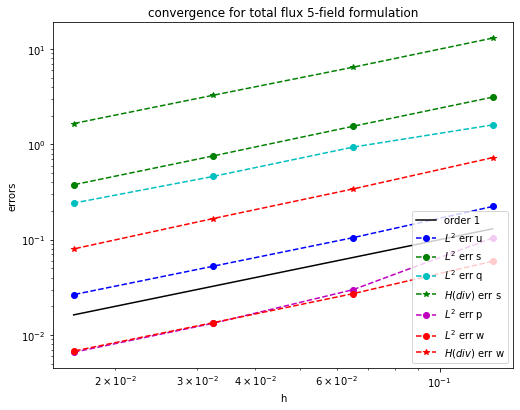

In [ ]:
# definition of the meshsize 
h = np.array([0.13/(2**i) for i in range(4)])

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.2, 0.2, 0.8, 0.8]) 

axes.loglog(h, h, 'k',label="order 1")
#axes.loglog(h, h**2, 'y',label="order 2")
axes.loglog(h, M_err[0,:], 'b--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--o',label="$L^2$ err s")
axes.loglog(h, M_err[2,:], 'c--o',label="$L^2$ err q")
axes.loglog(h, M_err[3,:], 'g--*',label="$H(div)$ err s")
axes.loglog(h, M_err[4,:], 'm--o',label="$L^2$ err p")
axes.loglog(h, M_err[5,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M_err[6,:], 'r--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.savefig("conv_mixedbiot.png", dpi=200)
plt.show()

## Monolithic mixed version

In [ ]:
def solve_mixedbiot(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S1 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    S2 = FiniteElement('BDM', mesh.ufl_cell(), 1)
    U = VectorElement('DG', mesh.ufl_cell(), 0)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 1)
    P = FiniteElement('DG', mesh.ufl_cell(), 0)
    X = FunctionSpace(mesh, MixedElement([S1, S2, U, Q, W, P]))

    # 3. assembling     
    s1, s2, u, q, w, phi = TrialFunctions(X)
    t1, t2, v, r, z, psi = TestFunctions(X)
    
    a1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    a2 = (u[0] * div(t1) + u[1] * div(t2) + v[0] * div(s1) + v[1] * div(s2)) * dx   
    a3 = beta * ((t1[0]+t2[1]) * phi + (s1[0]+s2[1]) * psi) * dx
    a4 = -(dt/kappa) * dot(w - (alpha/dt)*u, z - (alpha/dt)*v) * dx
    a5 = (dt * psi * div(w) + dt * phi * div(z) + c_1 * phi * psi)  * dx
    a6 = (r * (s1[1] - s2[0]) + q * (t1[1] - t2[0])) * dx 
    a = a1 + a2 + a3 + a4 + a5 + a6
    
    L = (dt*(g1+g2)*psi - dot(f1+f2,v))*dx

    # 4. solve
    x = Function(X)
    b = assemble(L)
    A = assemble(a)
    Ainv = LUSolver(A)
    Ainv.solve(x.vector(), b)
    s1, s2, u, q, w, phi = x.split()
    
    # 5. error evaluation
    Y = FunctionSpace(mesh, 'DG', 1)
    qproj = project(s1[1] - s2[0], Y)
           
    l2err_u = errornorm(u_ex, u, 'L2')
    l2err_s = sqrt(errornorm(s1_ex, s1, 'L2')**2 + errornorm(s2_ex, s2, 'L2')**2)
    Hdiverr_s = sqrt(errornorm(s1_ex, s1, 'Hdiv0')**2 + errornorm(s2_ex, s2, 'Hdiv0')**2)
    l2err_p = errornorm(p_ex, phi, 'L2')
    l2err_w = errornorm(w_ex, w, 'L2')
    Hdiverr_w = errornorm(w_ex, w, 'Hdiv0')
    l2err_q = norm(qproj, 'L2')

    return l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
M_err=np.zeros((7,4))

for i in range(4):
    n = 8*(2**i)
    l2err_u, l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = solve_mixedbiot(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    M_err[0,i] = l2err_u 
    M_err[1,i] = l2err_s
    M_err[2,i] = l2err_q 
    M_err[3,i] = Hdiverr_s
    M_err[4,i] = l2err_p 
    M_err[5,i] = l2err_w
    M_err[6,i] = Hdiverr_w

    print('n={} l2err_u={:.2e} l2err_s={:.2e} l2err_q={:.2e} Hdiverr_s={:.2e} '.format(n, l2err_u, l2err_s, l2err_q, Hdiverr_s))
    print('n={} l2err_p={:.2e} l2err_w={:.2e} Hdiverr_w={:.2e}'.format(n, l2err_p, l2err_w, Hdiverr_w))
    print()

n=8 l2err_u=2.14e-01 l2err_s=5.59e-01 l2err_q=1.27e-01 Hdiverr_s=1.30e+01 
n=8 l2err_p=1.75e-01 l2err_w=5.35e-03 Hdiverr_w=1.79e-02

n=16 l2err_u=1.03e-01 l2err_s=1.38e-01 l2err_q=3.23e-02 Hdiverr_s=6.43e+00 
n=16 l2err_p=6.37e-02 l2err_w=2.61e-03 Hdiverr_w=7.47e-03

n=32 l2err_u=5.22e-02 l2err_s=3.57e-02 l2err_q=8.60e-03 Hdiverr_s=3.27e+00 
n=32 l2err_p=2.39e-02 l2err_w=1.33e-03 Hdiverr_w=2.76e-03

n=64 l2err_u=2.63e-02 l2err_s=9.12e-03 l2err_q=2.14e-03 Hdiverr_s=1.65e+00 
n=64 l2err_p=8.80e-03 l2err_w=6.72e-04 Hdiverr_w=8.32e-04



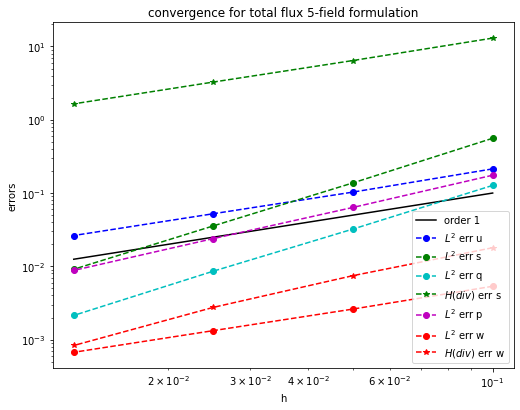

In [ ]:
# definition of the meshsize 
h = np.array([0.1/(2**i) for i in range(4)])

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.2, 0.2, 0.8, 0.8]) 

axes.loglog(h, h, 'k',label="order 1")
#axes.loglog(h, h**2, 'y',label="order 2")
axes.loglog(h, M_err[0,:], 'b--o',label="$L^2$ err u")
axes.loglog(h, M_err[1,:], 'g--o',label="$L^2$ err s")
axes.loglog(h, M_err[2,:], 'c--o',label="$L^2$ err q")
axes.loglog(h, M_err[3,:], 'g--*',label="$H(div)$ err s")
axes.loglog(h, M_err[4,:], 'm--o',label="$L^2$ err p")
axes.loglog(h, M_err[5,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, M_err[6,:], 'r--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.savefig("conv_mixedbiot.png", dpi=200)
plt.show()

## Monolithic dual version

In [ ]:
def solve_dualbiot(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2):
    # 0. method specific pre-computations
    beta = (1.0-alpha)/(2*(1.0+lam))
    gamma = lam/(4*(1.0+lam))
    c_1 = c_0 + ((1.0-alpha)**2)/(1.0+lam)
    
    # 1. mesh generation
    #mesh = UnitSquareMesh(n, n, 'crossed')
    square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
    mesh = generate_mesh(square, n)

    # 2. definition of a weak symmetry MFE stable coupling
    S1 = FiniteElement('RT', mesh.ufl_cell(), 2)
    S2 = FiniteElement('RT', mesh.ufl_cell(), 2)
    Q = FiniteElement('CG', mesh.ufl_cell(), 1)
    W = FiniteElement('RT', mesh.ufl_cell(), 2)
    P = FiniteElement('DG', mesh.ufl_cell(), 1)
    X = FunctionSpace(mesh, MixedElement([S1, S2, Q, W, P]))

    # 3. assembling     
    s1, s2, q, w, phi = TrialFunctions(X)
    t1, t2, r, z, psi = TestFunctions(X)
    
    a1 = (0.5 * (dot(s1, t1)+dot(s2, t2)) - gamma * (s1[0]+s2[1]) * (t1[0]+t2[1])) * dx
    a2 = (dt*kappa/(alpha**2))*(div(s1) * div(t1) + div(s2) * div(t2)) * dx   
    a3 = beta * ((t1[0]+t2[1]) * phi + (s1[0]+s2[1]) * psi) * dx
    a4 = (dt/alpha) * (w[0] * div(t1) + w[1] * div(t2) + z[0] * div(s1) + z[1] * div(s2)) * dx
    a5 = (dt * psi * div(w) + dt * phi * div(z) + c_1 * phi * psi)  * dx
    a6 = (r * (s1[1] - s2[0]) + q * (t1[1] - t2[0])) * dx 
    a = a1 + a2 + a3 + a4 + a5 + a6
    
    L1 = (dt*(g1+g2)*psi - (dt/alpha)*dot(f1+f2,z))*dx
    L2 = -(dt*kappa/(alpha**2))*((f1[0]+f2[0])*div(t1)+(f1[1]+f2[1])*div(t2))*dx
    L = L1 + L2

    # 4. solve
    x = Function(X)
    b = assemble(L)
    A = assemble(a)
    Ainv = LUSolver(A)
    Ainv.solve(x.vector(), b)
    s1, s2, q, w, phi = x.split()
    
    # 5. error evaluation
    Y = FunctionSpace(mesh, 'DG', 1)
    qproj = project(s1[1] - s2[0], Y)
           
    l2err_s = sqrt(errornorm(s1_ex, s1, 'L2')**2 + errornorm(s2_ex, s2, 'L2')**2)
    Hdiverr_s = sqrt(errornorm(s1_ex, s1, 'Hdiv0')**2 + errornorm(s2_ex, s2, 'Hdiv0')**2)
    l2err_p = errornorm(p_ex, phi, 'L2')
    l2err_w = errornorm(w_ex, w, 'L2')
    Hdiverr_w = errornorm(w_ex, w, 'Hdiv0')
    l2err_q = norm(qproj, 'L2')

    return l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w

In [ ]:
Md_err=np.zeros((6,4))

for i in range(4):
    n = 8*(2**i)
    l2err_s, l2err_p, l2err_w, l2err_q, Hdiverr_s, Hdiverr_w = solve_dualbiot(n, dt, lam, c_0, kappa, alpha, u_ex, p_ex, s1_ex, s2_ex, w_ex, f1, f2, g1, g2)

    Md_err[0,i] = l2err_s
    Md_err[1,i] = l2err_q 
    Md_err[2,i] = Hdiverr_s
    Md_err[3,i] = l2err_p 
    Md_err[4,i] = l2err_w
    Md_err[5,i] = Hdiverr_w

    print('n={} l2err_s={:.2e} l2err_q={:.2e} Hdiverr_s={:.2e} '.format(n, l2err_s, l2err_q, Hdiverr_s))
    print('n={} l2err_p={:.2e} l2err_w={:.2e} Hdiverr_w={:.2e}'.format(n, l2err_p, l2err_w, Hdiverr_w))
    print()

n=8 l2err_s=3.04e-01 l2err_q=2.06e-01 Hdiverr_s=1.43e+00 
n=8 l2err_p=2.98e-01 l2err_w=9.27e-04 Hdiverr_w=5.13e-02

n=16 l2err_s=7.23e-02 l2err_q=4.69e-02 Hdiverr_s=3.54e-01 
n=16 l2err_p=3.78e-02 l2err_w=1.47e-04 Hdiverr_w=7.47e-03

n=32 l2err_s=1.83e-02 l2err_q=1.23e-02 Hdiverr_s=9.05e-02 
n=32 l2err_p=5.27e-03 l2err_w=3.45e-05 Hdiverr_w=1.29e-03

n=64 l2err_s=4.58e-03 l2err_q=3.08e-03 Hdiverr_s=2.28e-02 
n=64 l2err_p=6.78e-04 l2err_w=8.66e-06 Hdiverr_w=2.61e-04



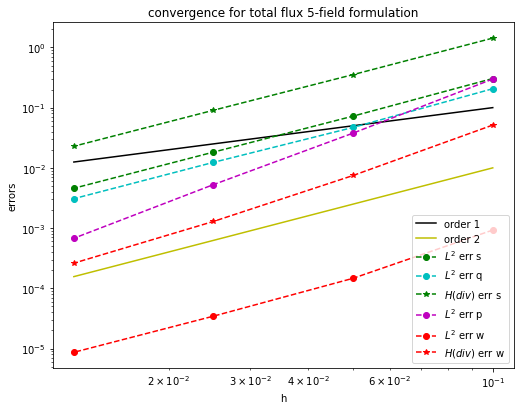

In [ ]:
# definition of the meshsize 
h = np.array([0.1/(2**i) for i in range(4)])

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.2, 0.2, 0.8, 0.8]) 

axes.loglog(h, h, 'k',label="order 1")
axes.loglog(h, h**2, 'y',label="order 2")
axes.loglog(h, Md_err[0,:], 'g--o',label="$L^2$ err s")
axes.loglog(h, Md_err[1,:], 'c--o',label="$L^2$ err q")
axes.loglog(h, Md_err[2,:], 'g--*',label="$H(div)$ err s")
axes.loglog(h, Md_err[3,:], 'm--o',label="$L^2$ err p")
axes.loglog(h, Md_err[4,:], 'r--o',label="$L^2$ err w")
axes.loglog(h, Md_err[5,:], 'r--*',label="$H(div)$ err w")

axes.set_title("convergence for total flux 5-field formulation");
axes.set_xlabel("h")
axes.set_ylabel("errors")
axes.legend(loc=4)

fig.savefig("conv_mixedbiot.png", dpi=200)
plt.show()